# This Data Mining Workflow uses both Pipefitter and SWAT

## Set up the Jupyter Notebook for Analysis

In [1]:
# Import necessary packages and modules
import swat, collections
import pandas as pd
import matplotlib.pyplot as plt
from pipefitter.pipeline import Pipeline
from pipefitter.transformer import Imputer
from pipefitter.estimator import DecisionTree, DecisionForest, GBTree, NeuralNetwork
%matplotlib inline

# Set the connection by specifying the hostname, port, username, and password
conn = swat.CAS(host, port, username, password)

# Data set shortcut
indata = 'hmeq'

# Create a CAS library called DMLib pointing to the defined server-side directory
DMLib = conn.addCaslib('DMlib', datasource = 'path', path = '/viyafiles')

# Do a server-side data load into CAS memory
castbl = conn.loadTable(indata + '.sas7bdat', casOut = indata)['casTable']
castbl.replace = True

NOTE: 'DMlib' is now the active caslib.
NOTE: Cloud Analytic Services added the caslib 'DMlib'.
NOTE: Cloud Analytic Services made the file hmeq.sas7bdat available as table HMEQ in caslib DMlib.


## Get the first few rows

In [2]:
# Assign the variable name df to the new CASTable object
df = conn.CASTable(indata)

# Perform the head method to return the first 5 rows
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1.0,1100.0,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1.0,1300.0,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1.0,1500.0,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1.0,1500.0,NaN,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,1700.0,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


## Feature engineering

In [3]:
# Create new columns to help with analysis
df['MORTPAID'] = df['VALUE'] - df['MORTDUE']
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,MORTPAID
0,1.0,1100.0,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN,13165.0
1,1.0,1300.0,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN,-1653.0
2,1.0,1500.0,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN,3200.0
3,1.0,1500.0,NaN,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,1700.0,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN,14200.0


## Investigate the data

### Variable types

In [4]:
# Get the variable types
df.dtypes

BAD         double
LOAN        double
MORTDUE     double
VALUE       double
REASON        char
JOB           char
YOJ         double
DEROG       double
DELINQ      double
CLAGE       double
NINQ        double
CLNO        double
DEBTINC     double
MORTPAID    double
dtype: object

### Summary statistics

In [5]:
# Get summary statistics using the describe method, then switch rows and columns
summary = df.describe(include = 'all').transpose()
summary

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
BAD,5960,2,0,4771,0.199497,0.399656,0,0,0,0,1
LOAN,5960,540,15000,105,18608,11207.5,1100,11100,16300,23300,89900
MORTDUE,5442,5053,42000,11,73760.8,44457.6,2063,46268,65019,91491,399550
VALUE,5848,5381,60000,15,101776,57385.8,8000,66069,89235.5,119832,855909
REASON,5960,2,DebtCon,3928,NaN,NaN,DebtCon,NaN,NaN,NaN,HomeImp
JOB,5960,6,Other,2388,NaN,NaN,Mgr,NaN,NaN,NaN,Self
YOJ,5445,99,0,415,8.92227,7.57398,0,3,7,13,41
DEROG,5252,11,0,4527,0.25457,0.846047,0,0,0,0,10
DELINQ,5380,14,0,4179,0.449442,1.12727,0,0,0,0,15
CLAGE,5652,5314,206.967,7,179.766,85.8101,0,115.103,173.467,231.575,1168.23


### Numeric variable distribution

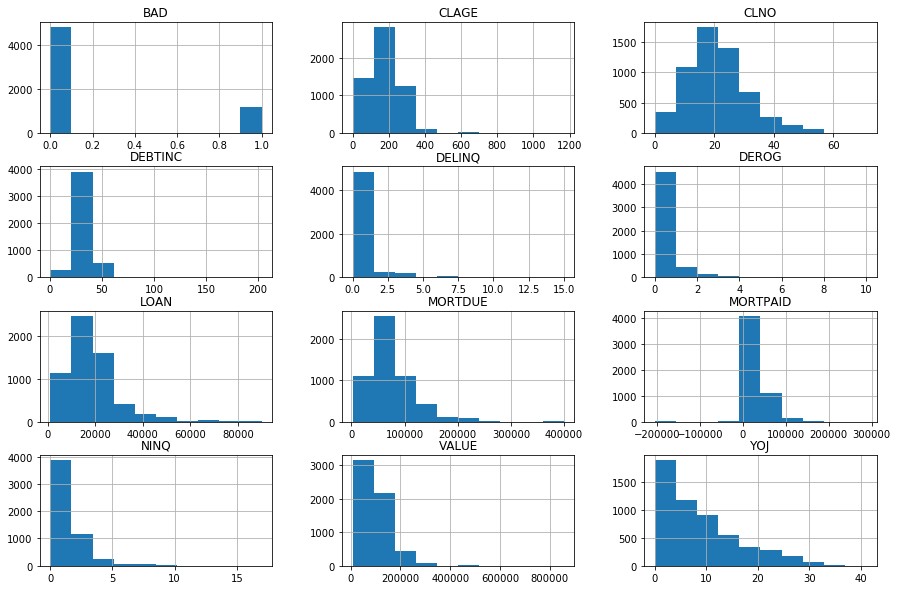

In [6]:
# Get the distribution of all numeric variables
df.hist(figsize = (15, 10));

### Investigate missingness

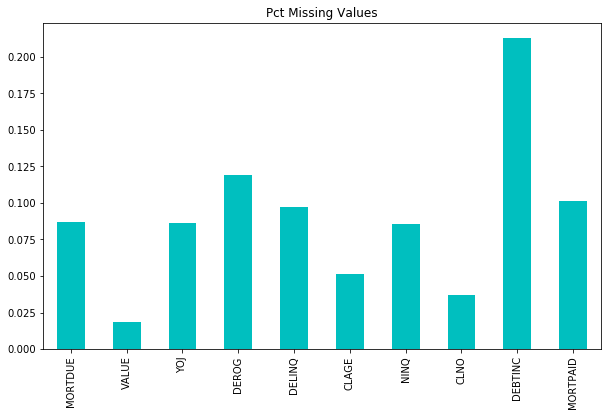

In [7]:
# Create percent missing column for plotting
summary['pctmiss'] = (len(castbl) - summary['count'])/len(castbl)

# Make a bar graph using pandas/matplotlib functionality
summary.query('pctmiss > 0')['pctmiss'].plot('bar', title = 'Pct Missing Values', figsize = (10, 6), color = 'c');

## Split the data into training and validation before imputing

In [8]:
# Load the sampling actionset
conn.loadactionset('sampling')

# Do a simple random sample with a 70/30 split
df.srs(samppct = 70, partind = True, output = dict(casout = castbl, copyvars = 'all'))

# Verify that the partition worked using the groupby method
castbl.groupby('_PartInd_')['_PartInd_'].count()/len(castbl)

NOTE: Added action set 'sampling'.
NOTE: Using SEED=329570658 for sampling.


_PartInd_
0.0    0.3
1.0    0.7
Name: _PartInd_, dtype: float64

## Impute missing values using pipefitter pipelines

In [9]:
# Will end up imputing the median value for numeric variables, most common value for nominal
imp_castbl = Pipeline([Imputer(Imputer.MEDIAN), Imputer(Imputer.MODE)]).transform(castbl)

# I want my imputed dataset name to have the imp_ prefix
imp_castbl.partition(casout = dict(name = 'imp_' + indata, replace = True))

# Remove the unnecessary impute staging tables
[conn.droptable(s) for s in conn.tableinfo()['TableInfo']['Name'] if 'IMPUTE' in s]

# Make sure everything worked properly for the new imputed dataset
conn.fetch('imp_' + indata, to = 5)

NOTE: Cloud Analytic Services dropped table IMPUTE_5373D5ED_F76F_4317_B212_B8DD29E6C53F from caslib DMlib.
NOTE: Cloud Analytic Services dropped table IMPUTE_15245ACF_D875_40E4_850D_C4CDAADD6851 from caslib DMlib.


,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,MORTPAID,_PartInd_
0,1.0,1100.0,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,34.818262,13165.0,1.0
1,1.0,1300.0,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,34.818262,-1653.0,1.0
2,1.0,1500.0,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,34.818262,3200.0,1.0
3,1.0,1500.0,65019.0,89235.5,DebtCon,Other,7.0,0.0,0.0,173.466667,1.0,20.0,34.818262,26623.0,0.0
4,0.0,1700.0,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,34.818262,14200.0,1.0


### Do a quick check on the available datasets

In [10]:
conn.tableinfo()

,Name,Rows,Columns,Encoding,CreateTimeFormatted,ModTimeFormatted,JavaCharSet,CreateTime,ModTime,Global,Repeated,View,SourceName,SourceCaslib,Compressed,Creator,Modifier
0,HMEQ,5960,15,utf-8,17Apr2017:17:57:14,17Apr2017:17:57:14,UTF8,1.808071e+09,1.808071e+09,0,0,0,,,0,jelueb,
1,IMP_HMEQ,5960,15,utf-8,17Apr2017:17:57:15,17Apr2017:17:57:15,UTF8,1.808071e+09,1.808071e+09,0,0,0,,,0,jelueb,


## Prepare for modeling - shortcuts to make life easier

In [11]:
# Create CASTable objects for training and validation for models that can handle missing values
train = conn.CASTable(indata, where = '_partind_ = 1')
valid = conn.CASTable(indata, where = '_partind_ = 0')

# Create CASTable objects for training and validation for models that cannot handle missing values
imp_train = conn.CASTable('imp_' + indata, where = '_partind_ = 1')
imp_valid = conn.CASTable('imp_' + indata, where = '_partind_ = 0')

# Key word argument shortcuts for model building (common imputs)
params = dict(
    target = castbl.columns[0],
    inputs = castbl.columns[1:-1].tolist(),
    nominals = [castbl.columns[0]] + castbl.columninfo()['ColumnInfo'].query('Type == "varchar"')['Column'].tolist()
)

# Model Fitting & Scoring using Pipefitter

## Decision Tree

In [12]:
# Train decision tree on training dataset
dt = DecisionTree(**params).fit(train)

# Score decision tree on validation dataset
dt_score = dt.score(valid)
dt_score

Target                            BAD
Level                           CLASS
Var                            _DT_P_
NBins                             100
NObsUsed                         1788
TargetCount                      1788
TargetMiss                          0
PredCount                        1788
PredMiss                            0
Event                               0
EventCount                       1415
NonEventCount                     373
EventMiss                           0
AreaUnderROCCurve            0.826011
CRCut                            0.72
ClassificationCutOff              0.5
KS                           0.630406
KSCutOff                         0.72
MisClassificationRate          14.094
dtype: object

## Random Forest

In [13]:
# Train random forest on training dataset
rf = DecisionForest(**params).fit(train)

# Score decision tree on validation dataset
rf_score = rf.score(valid)
rf_score

Target                            BAD
Level                           CLASS
Var                            _RF_P_
NBins                             100
NObsUsed                         1788
TargetCount                      1788
TargetMiss                          0
PredCount                        1788
PredMiss                            0
Event                               0
EventCount                       1415
NonEventCount                     373
EventMiss                           0
AreaUnderROCCurve            0.877359
CRCut                            0.58
ClassificationCutOff              0.5
KS                           0.654803
KSCutOff                         0.83
MisClassificationRate         11.9128
dtype: object

## Gradient Boosting

In [14]:
# Train gradient boosting on training dataset
gbt = GBTree(**params).fit(train)

# Score gradient boosting on validation dataset
gbt_score = gbt.score(valid)
gbt_score

Target                            BAD
Level                           CLASS
Var                           _GBT_P_
NBins                             100
NObsUsed                         1788
TargetCount                      1788
TargetMiss                          0
PredCount                        1788
PredMiss                            0
Event                               0
EventCount                       1415
NonEventCount                     373
EventMiss                           0
AreaUnderROCCurve            0.937564
CRCut                            0.59
ClassificationCutOff              0.5
KS                           0.734302
KSCutOff                         0.75
MisClassificationRate         9.67562
dtype: object

## Neural Network

In [15]:
# Train neural network on training dataset
nn = NeuralNetwork(**params).fit(imp_train)

# Score neural network on validation dataset
nn_score = nn.score(imp_valid, event = 0)
nn_score

Target                            BAD
Level                           CLASS
Var                            _NN_P_
NBins                             100
NObsUsed                         1788
TargetCount                      1788
TargetMiss                          0
PredCount                        1788
PredMiss                            0
Event                               1
EventCount                        373
NonEventCount                    1415
EventMiss                           0
AreaUnderROCCurve             0.75782
CRCut                            0.47
ClassificationCutOff              0.5
KS                           0.401029
KSCutOff                         0.21
MisClassificationRate          17.226
dtype: object

# Model Assessment

## Compare model misclassification side-by-side

In [16]:
# Aggregate the misclassification metrics from previous output
Models = ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'Neural Network']
Misclassification = [dt_score[-1], rf_score[-1], gbt_score[-1], nn_score[-1]]
mcr = pd.DataFrame({'Misclassification Rate': Misclassification}, Models).sort_values('Misclassification Rate')
print('\n', mcr)

# Which model is the champion?
print('\n', 'The', mcr.index[0], 'model is the champion!')


                    Misclassification Rate
Gradient Boosting                9.675615
Random Forest                   11.912752
Decision Tree                   14.093960
Neural Network                  17.225951

 The Gradient Boosting model is the champion!


# Optional: obtain more model assessment metrics

## Check available tables
There should be the prepared datasets and saved models

In [17]:
# What are the in-memory tables?
conn.tableinfo()

,Name,Rows,Columns,Encoding,CreateTimeFormatted,ModTimeFormatted,JavaCharSet,CreateTime,ModTime,Global,Repeated,View,SourceName,SourceCaslib,Compressed,Creator,Modifier
0,HMEQ,5960,15,utf-8,17Apr2017:17:57:14,17Apr2017:17:57:14,UTF8,1.808071e+09,1.808071e+09,0,0,0,,,0,jelueb,
1,IMP_HMEQ,5960,15,utf-8,17Apr2017:17:57:15,17Apr2017:17:57:15,UTF8,1.808071e+09,1.808071e+09,0,0,0,,,0,jelueb,
2,KMODELTREEF6BEF868_5BEF_4F67_8A03_938A7038CA83,13,28,utf-8,17Apr2017:17:57:16,17Apr2017:17:57:16,UTF8,1.808071e+09,1.808071e+09,0,0,0,,,0,jelueb,
3,KMODELFOREST_D99A1A67_3A12_4E87_B8B2_92A01EE175B9,690,42,utf-8,17Apr2017:17:57:16,17Apr2017:17:57:16,UTF8,1.808071e+09,1.808071e+09,0,0,0,,,0,jelueb,
4,KMODELGBT_27489703_D6BA_4135_A2E2_3F04DF8BB81B,2480,32,utf-8,17Apr2017:17:57:24,17Apr2017:17:57:24,UTF8,1.808071e+09,1.808071e+09,0,0,0,,,0,jelueb,
5,NNMODEL2E2DE424_B238_4FAE_9FD3_B470212B80FD,182,15,utf-8,17Apr2017:17:57:27,17Apr2017:17:57:27,UTF8,1.808071e+09,1.808071e+09,0,0,0,,,0,jelueb,


### Assessment dictionary shortcuts

In [18]:
# Give model tables appropriate shortcuts in a dictionary
saved = {}
saved['dt']  = next((s for s in conn.tableinfo()['TableInfo']['Name'] if 'MODELTREE' in s), None)
saved['rf']  = next((s for s in conn.tableinfo()['TableInfo']['Name'] if 'MODELFOREST' in s), None)
saved['gbt'] = next((s for s in conn.tableinfo()['TableInfo']['Name'] if 'MODELGBT' in s), None)
saved['nn']  = next((s for s in conn.tableinfo()['TableInfo']['Name'] if 'NNMODEL' in s), None)

# Models to be assessed
models = collections.OrderedDict()
models['dt']  = 'Decision Tree'
models['rf']  = 'Random Forest'
models['gbt'] = 'Gradient Boosting'
models['nn']  = 'Neural Network'

## Score the models built using Pipefitter

In [19]:
# Define function that will score the models based on the model prefix
def score_model(model):
    return dict(
        table        = valid,
        modelTable   = saved[model],
        assessonerow = True,
        copyvars     = [castbl.columns[0], castbl.columns[-1]],
        casOut       = dict(name = model + '_scored', replace = True)
    )

### Decision Tree
conn.dtreeScore(**score_model('dt'))

### Random Forest
conn.forestScore(**score_model('rf'))

### Gradient Boosting
conn.gbtreeScore(**score_model('gbt'))

### Neural Network
conn.annScore(**score_model('nn'))

# See the available tables now
conn.tableinfo()

,Name,Rows,Columns,Encoding,CreateTimeFormatted,ModTimeFormatted,JavaCharSet,CreateTime,ModTime,Global,Repeated,View,SourceName,SourceCaslib,Compressed,Creator,Modifier
0,HMEQ,5960,15,utf-8,17Apr2017:17:57:14,17Apr2017:17:57:14,UTF8,1.808071e+09,1.808071e+09,0,0,0,,,0,jelueb,
1,IMP_HMEQ,5960,15,utf-8,17Apr2017:17:57:15,17Apr2017:17:57:15,UTF8,1.808071e+09,1.808071e+09,0,0,0,,,0,jelueb,
2,KMODELTREEF6BEF868_5BEF_4F67_8A03_938A7038CA83,13,28,utf-8,17Apr2017:17:57:16,17Apr2017:17:57:16,UTF8,1.808071e+09,1.808071e+09,0,0,0,,,0,jelueb,
3,KMODELFOREST_D99A1A67_3A12_4E87_B8B2_92A01EE175B9,690,42,utf-8,17Apr2017:17:57:16,17Apr2017:17:57:16,UTF8,1.808071e+09,1.808071e+09,0,0,0,,,0,jelueb,
4,KMODELGBT_27489703_D6BA_4135_A2E2_3F04DF8BB81B,2480,32,utf-8,17Apr2017:17:57:24,17Apr2017:17:57:24,UTF8,1.808071e+09,1.808071e+09,0,0,0,,,0,jelueb,
5,NNMODEL2E2DE424_B238_4FAE_9FD3_B470212B80FD,182,15,utf-8,17Apr2017:17:57:27,17Apr2017:17:57:27,UTF8,1.808071e+09,1.808071e+09,0,0,0,,,0,jelueb,
6,DT_SCORED,1788,16,utf-8,17Apr2017:17:57:28,17Apr2017:17:57:28,UTF8,1.808071e+09,1.808071e+09,0,0,0,,,0,jelueb,
7,RF_SCORED,1788,9,utf-8,17Apr2017:17:57:28,17Apr2017:17:57:28,UTF8,1.808071e+09,1.808071e+09,0,0,0,,,0,jelueb,
8,GBT_SCORED,1788,8,utf-8,17Apr2017:17:57:28,17Apr2017:17:57:28,UTF8,1.808071e+09,1.808071e+09,0,0,0,,,0,jelueb,
9,NN_SCORED,1788,6,utf-8,17Apr2017:17:57:28,17Apr2017:17:57:28,UTF8,1.808071e+09,1.808071e+09,0,0,0,,,0,jelueb,


## Assess the models using the scored datasets

In [20]:
# Model assessment function
def assess_model(model):
    return conn.assess(
        table    = dict(name = model + '_scored', where = '_partind_ = 0'),
        inputs   = '_' + model + '_p_           1',      
        response = castbl.columns[0],
        event    = '1'  
    )

# Loop through the models and append to the roc_df dataframe
roc_df  = pd.DataFrame()
for i in range(len(models)):
    tmp = assess_model(list(models)[i])
    tmp.ROCInfo['Model'] = list(models.values())[i]
    roc_df = pd.concat([roc_df, tmp.ROCInfo])

## Additional Assessment

### Confusion Matrix

In [21]:
# Display stacked confusion matrix
print('\n', 'Confusion Matrix Information'.center(38, ' '))
roc_df[round(roc_df['CutOff'], 2) == 0.5][['Model', 'TP', 'FP', 'FN', 'TN']].reset_index(drop = True)


      Confusion Matrix Information     


,Model,TP,FP,FN,TN
0,Decision Tree,273.0,153.0,100.0,1262.0
1,Random Forest,100.0,2.0,273.0,1413.0
2,Gradient Boosting,254.0,65.0,119.0,1350.0
3,Neural Network,22.0,22.0,73.0,890.0


### ROC Curve

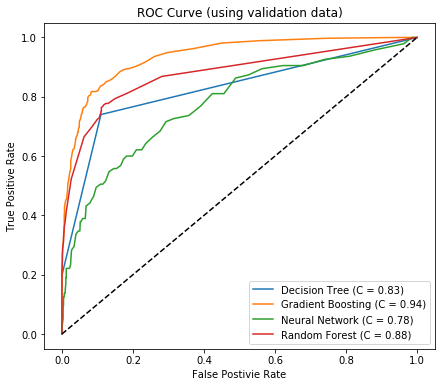

In [22]:
# Plot ROC curve
plt.figure(figsize = (7, 6))
for key, grp in roc_df.groupby(['Model']):
    plt.plot(grp['FPR'], grp['Sensitivity'], label = key + ' (C = %0.2f)' % grp['C'].mean())
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.title('ROC Curve (using validation data)');

## End the session

In [23]:
# End the session
conn.endsession()

+ Elapsed: 0.0198s, user: 0.002s, sys: 0.004s, mem: 0.109mb